In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

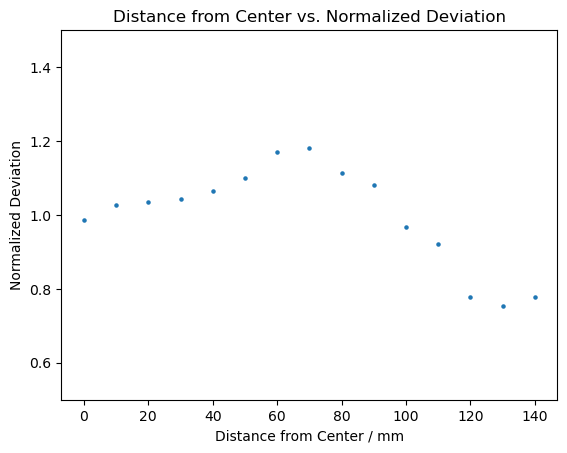

In [72]:
# Constants
PLATE_X = 237.62
PLATE_Y = 237.62
CENTER_X = PLATE_X / 2
CENTER_Y = PLATE_Y / 2

# Data points
distances = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
normalized_deviations = [0.985, 1.027, 1.034, 1.044, 1.065, 1.10, 1.17, 1.18, 1.114, 1.082, 0.967, 0.922, 0.779, 0.754, 0.779]

plt.scatter(distances, normalized_deviations, s=5)
plt.ylim(0.5, 1.5)
plt.xlabel('Distance from Center / mm')
plt.ylabel('Normalized Deviation')
plt.title('Distance from Center vs. Normalized Deviation')
plt.show()

Equation: 0.219 / (1 + exp(-0.098 * (x - 49.135))) + -0.491 / (1 + exp(-0.084 * (x - 99.751))) + 1.009


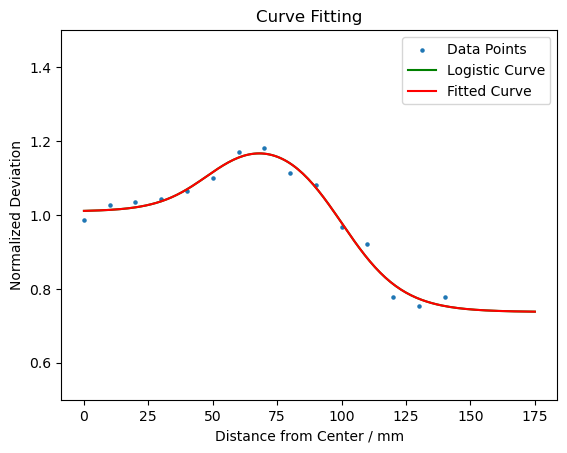

In [70]:
# Fit with logistic function and cubic spline to clamp boundary conditions

distances = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
normalized_deviations = [0.985, 1.027, 1.034, 1.044, 1.065, 1.10, 1.17, 1.18, 1.114, 1.082, 0.967, 0.922, 0.779, 0.754, 0.779]

# Define the curve function
def curve_func(x, a1, b1, c1, a2, b2, c2, d):
    return c1 / (1 + np.exp(-a1 * (x - b1))) + c2 / (1 + np.exp(-a2 * (x - b2))) + d

initial_guesses = [0.1, 50, 0.25, 0.08, 100, -0.55, 1]

# Perform the curve fitting
popt, pcov = curve_fit(curve_func, distances, normalized_deviations, p0=initial_guesses, maxfev=5000)
print(f'Equation: {popt[2]:.3f} / (1 + exp(-{popt[0]:.3f} * (x - {popt[1]:.3f}))) + {popt[5]:.3f} / (1 + exp(-{popt[3]:.3f} * (x - {popt[4]:.3f}))) + {popt[6]:.3f}')

# Generate x values for the curve
x_curve = np.arange(0, 176, 1)

# Generate y values using the fitted curve parameters
y_logistic = curve_func(x_curve, *popt)

# Fit with cubic spline to fix boundary conditions
cs = CubicSpline(x_curve, y_logistic, bc_type=((1, 0.), (1, 0.)))

# Generate y values using the fitted curve parameters
y_spline = cs(x_curve)

# Plot the original data points and the fitted curve
plt.scatter(distances, normalized_deviations, s=5, label='Data Points')
plt.plot(x_curve, y_logistic, 'g-', label='Logistic Curve')
plt.plot(x_curve, y_spline, 'r-', label='Fitted Curve')
plt.xlabel('Distance from Center / mm')
plt.ylabel('Normalized Deviation')
plt.ylim(0.5, 1.5)
plt.title('Curve Fitting')
plt.legend()
plt.show()

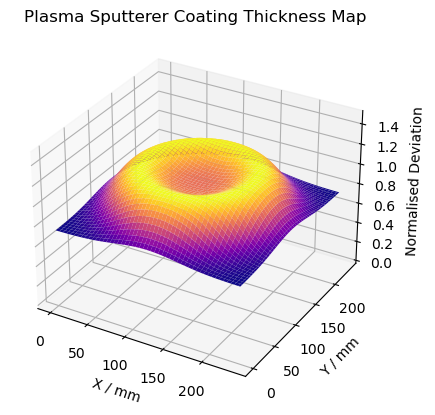

In [243]:
# Plot profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)
zz_ = cs(np.sqrt((xx_ - CENTER_X) ** 2 + (yy_ - CENTER_Y) ** 2))

# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the surface
ax.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Normalised Deviation')
ax.set_zlim(0, 1.5)
ax.set_title('Plasma Sputterer Coating Thickness Map')

# Display the plot
plt.show()


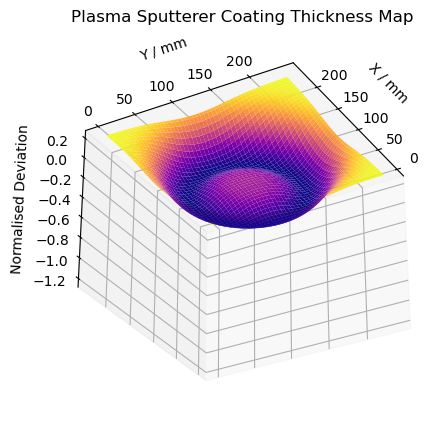

In [242]:
# Plot profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)
zz_ = -cs(np.sqrt((xx_ - CENTER_X) ** 2 + (yy_ - CENTER_Y) ** 2)) + 1

# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(-30, 30)

# Plot the surface
ax.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Normalised Deviation')
ax.set_zlim(-1.25, 0.25)
ax.set_title('Plasma Sputterer Coating Thickness Map', pad=20)

# Display the plot
plt.show()

#### Fit Profile into Tape Targets

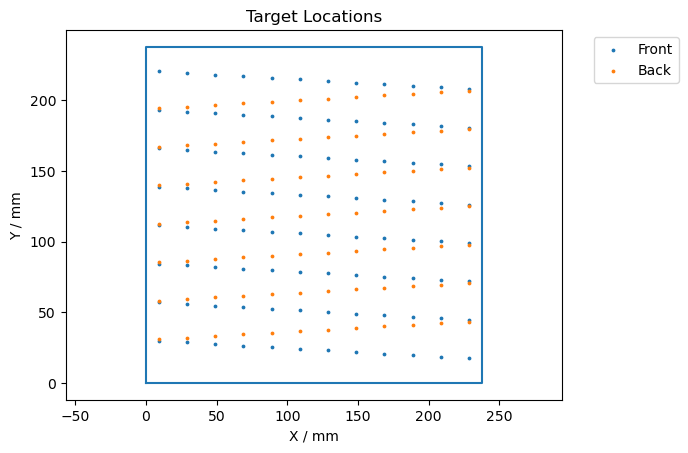

In [183]:
# Read the data from the csv file
front_data = np.genfromtxt("front_data.csv", delimiter=",")
front_x = front_data[:, 0]
front_y = -front_data[:, 1] # Flip the y values cause drawing coordinate is upside down

back_data = np.genfromtxt("back_data.csv", delimiter=",")
back_x = back_data[:, 0]
back_y = -back_data[:, 1] # Flip the y values cause drawing coordinate is upside down

# Plot a square
square_x = [0, PLATE_X, PLATE_X, 0, 0]
square_y = [0, 0, PLATE_Y, PLATE_Y, 0]
plt.plot(square_x, square_y)
plt.scatter(-front_x+PLATE_X, front_y, s=3, c='C0', label='Front') # Flip the x values for plotting only
plt.scatter(back_x, back_y, s=3, c='C1', label='Back')
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.axis("equal")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Target Locations')
plt.show()

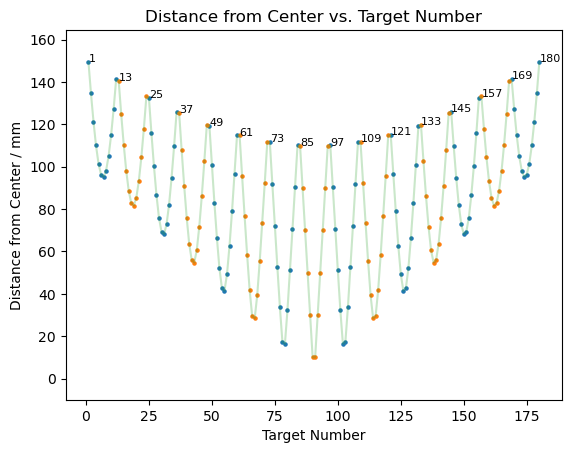

In [213]:
# Get distance of targets from center
front_radii = np.sqrt((front_x - CENTER_X) ** 2 + (front_y - CENTER_Y) ** 2)
back_radii = np.sqrt((back_x - CENTER_X) ** 2 + (back_y - CENTER_Y) ** 2)

merged_radii = []
for i in range(0, len(front_radii), 12):
    merged_radii.extend(front_radii[i:i+12])
    merged_radii.extend(back_radii[i:i+12])

n = np.arange(1, 181)
arg_n = np.where(((n-1) // 12) % 2 == 1, 0, 1)
front_n = n[arg_n == 1]
back_n = n[arg_n == 0]

# Add data labels to points
for i in range(0, len(n), 12):
    plt.annotate(str(i+1), (n[i], merged_radii[i]), fontsize=8)
plt.annotate(str(180), (n[-1], merged_radii[-1]), fontsize=8)

plt.scatter(front_n, front_radii, s=5)
plt.scatter(back_n, back_radii, s=5)
plt.plot(n, merged_radii, c='C2', alpha=0.25)
plt.xlabel('Target Number')
plt.ylabel('Distance from Center / mm')
plt.ylim(-10, np.max(merged_radii) + 15)
plt.title('Distance from Center vs. Target Number')
plt.show()

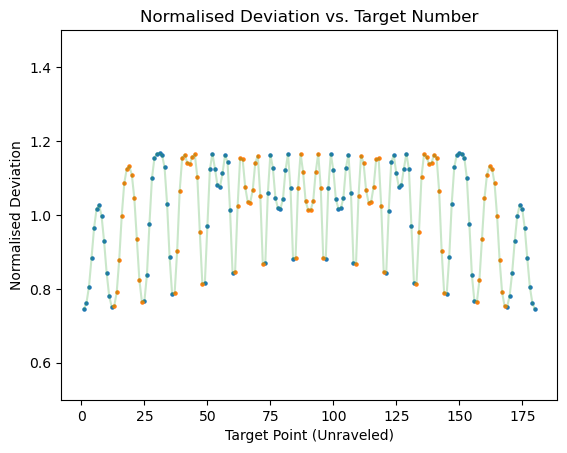

In [214]:
# Fit profile
front_deviation = cs(front_radii)
back_deviation = cs(back_radii)

# Add data labels to points
for i in range(0, len(n), 12):
    plt.annotate(str(i+1), (n[i], merged_radii[i]), fontsize=8)
plt.annotate(str(180), (n[-1], merged_radii[-1]), fontsize=8)

target_deviation = cs(merged_radii)
plt.xlabel('Target Point (Unraveled)')
plt.ylabel('Normalised Deviation')
plt.ylim(0.5, 1.5)
plt.plot(n, target_deviation, c='C2', alpha=0.25)
plt.scatter(front_n, front_deviation, s=5)
plt.scatter(back_n, back_deviation, s=5)
plt.title('Normalised Deviation vs. Target Number')
plt.show()

In [236]:
# Export data as df in csv
import pandas as pd
df = pd.DataFrame({'Target Number': n, 'Normalised Deviation': target_deviation})
df.to_csv('target_data.csv', index=False)

#### 3D Plot

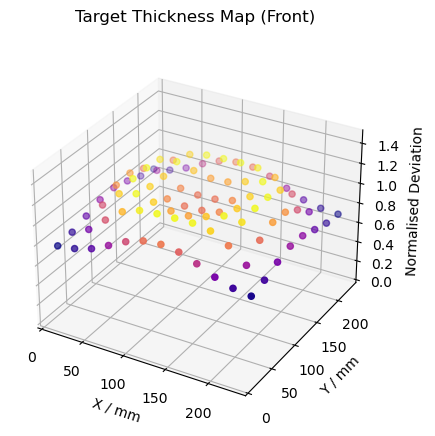

In [230]:
# Separate the columns of the data array
x = front_data[:, 0]
y = -front_data[:, 1]
z = front_deviation

# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the data points
ax.scatter3D(x, y, z, c=z, cmap='plasma')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Normalised Deviation')
ax.set_xlim(0, PLATE_X)
ax.set_ylim(0, PLATE_Y)
ax.set_zlim(0, 1.5)
ax.set_title('Target Thickness Map (Front)', pad=20)

# Display the plot
plt.show()

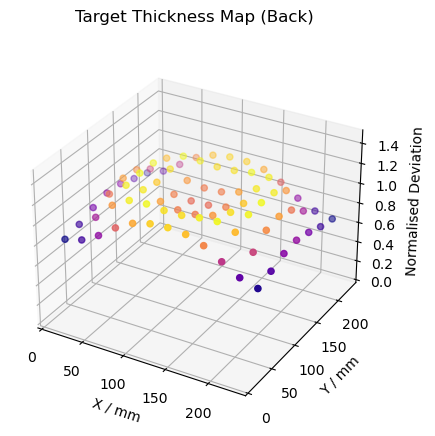

In [231]:
# Separate the columns of the data array
x = back_data[:, 0]
y = -back_data[:, 1]
z = back_deviation

# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the data points
ax.scatter3D(x, y, z, c=z, cmap='plasma')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Normalised Deviation')
ax.set_xlim(0, PLATE_X)
ax.set_ylim(0, PLATE_Y)
ax.set_zlim(0, 1.5)
ax.set_title('Target Thickness Map (Back)', pad=20)

# Display the plot
plt.show()